# Identification of Static Nonlinearities

We will define the problem of system identification and have a look at a simple example where we use a simple
feed-forward neural network to model our unknown system.

## What is System Identification?
The general setup for system identification is depicted in the figure below. We observe an input signal $x[n]$ and
corresponding measurements $y[n]$ of the system's output $f(x[n])$ that are corrupted by measurement noise $\nu[n]$.
The goal of system identification is now to find an approximate system $\hat{f}(\cdot)$ that "behaves as similarly as
possible to the true system $f(\cdot)$".

<img src="../../data/figures/system-identification.png" alt="System Identification Schematic" width="600" />

What does "as similar as possible" actually mean? We can characterize the approximation quality by considering
(functions of) the error signal $e[n] = \hat{y}[n] - y[n]$. Here we will use a standard measure, the mean squared error
(MSE) $J = \frac{1}{N} \sum_{n=1}^N e[n]^2$, that comes as a natural consequence when we assume that the noise $\nu$
 is normally distributed. See the class notes for more details.

**Importantly, be aware that we make several assumptions here:**
 - The system $f(\cdot)$ is deterministic.
 - The measurements $y[n]$ are corrupted with additive noise, whereas they could arbitrarily depend on the noise!
 - We assume that $x[n]$ and $y[n]$ are scalars.

We will further assume that $f(\cdot)$ is a static (memory-less) nonlinearity.

So let's get started. First, we need some imports.

In [1]:
%reload_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import numpy as np

from src.models.simple_mlp import SimpleMLP
from src.utils.plotting import init_plot_style

# initialize our global plot style
init_plot_style()

Now we create our true system that we want to identify later on and plot its input/output response.

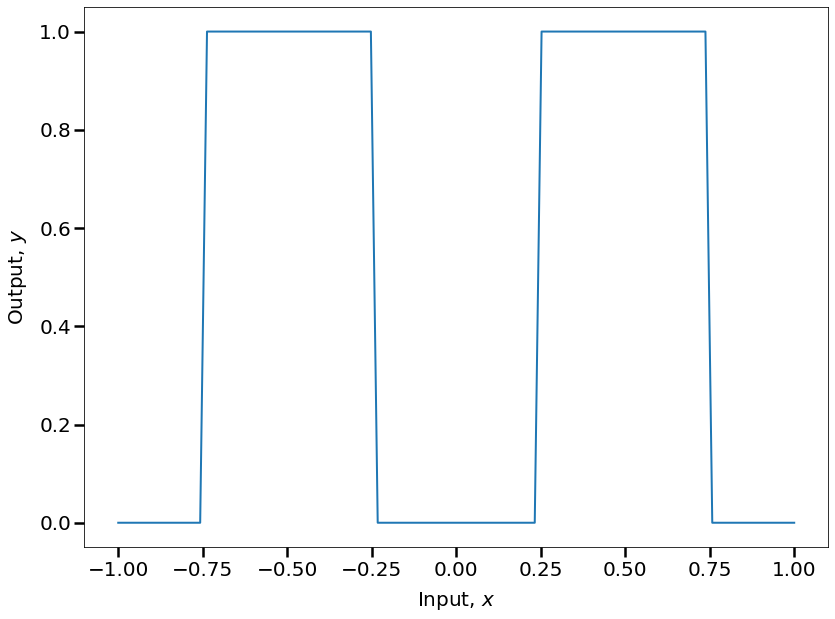

In [2]:
def system(x):
    """Implements a deterministic, static nonlinearity.

    Parameters
    ----------
    x : float or numpy.ndarray
        The systems input.

    Returns
    ------
    float or numpy.ndarray
        The corresponding system output.
    """
    y = np.ones_like(x)
    y[np.abs(x) < 0.25] = 0
    y[np.abs(x) > 0.75] = 0
    return y

# sample support and compute system output
support = np.linspace(-1, 1, 100)
true_output = system(support)

# plot the input/output behavior
plt.figure()
plt.plot(support, true_output)
plt.xlabel('Input, $x$')
plt.ylabel('Output, $y$')
plt.tight_layout()

We can now generate a training and test set by drawing samples uniformly at random from the system's support,
propagating them over the system and corrupting them with additive white Gaussian noise.

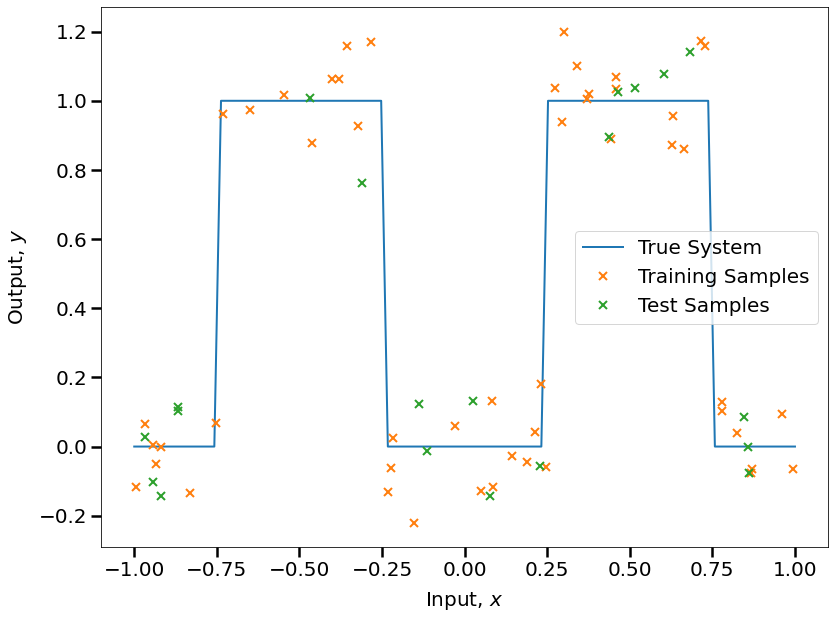

In [3]:
n_train = 50 # number of training samples
n_test = 20 # number of test samples
rng = np.random.default_rng(seed=0)

x_train = rng.uniform(size=n_train) * 2.0 - 1.0 # draw samples from support
noise = rng.normal(loc=0, scale=0.1, size=n_train) # generate noise
y_train = system(x_train) + noise # simulate measurements

x_test = rng.uniform(size=n_test) * 2.0 - 1.0 # draw samples from support
noise = rng.normal(loc=0, scale=0.1, size=n_test) # generate noise
y_test = system(x_test) + noise # simulate measurements

# plot the true system's response with training and test samples
plt.figure()
plt.plot(support, true_output, label='True System')
plt.plot(x_train, y_train, 'x', label='Training Samples')
plt.plot(x_test, y_test, 'x', label='Test Samples')
plt.xlabel('Input, $x$')
plt.ylabel('Output, $y$')
plt.legend()
plt.tight_layout()

We are now ready to fit our simple neural network to the system.

Epoch 0 training loss is 0.30
Epoch 50 training loss is 0.25
Epoch 100 training loss is 0.17
Epoch 150 training loss is 0.05
Epoch 200 training loss is 0.04
Epoch 250 training loss is 0.03


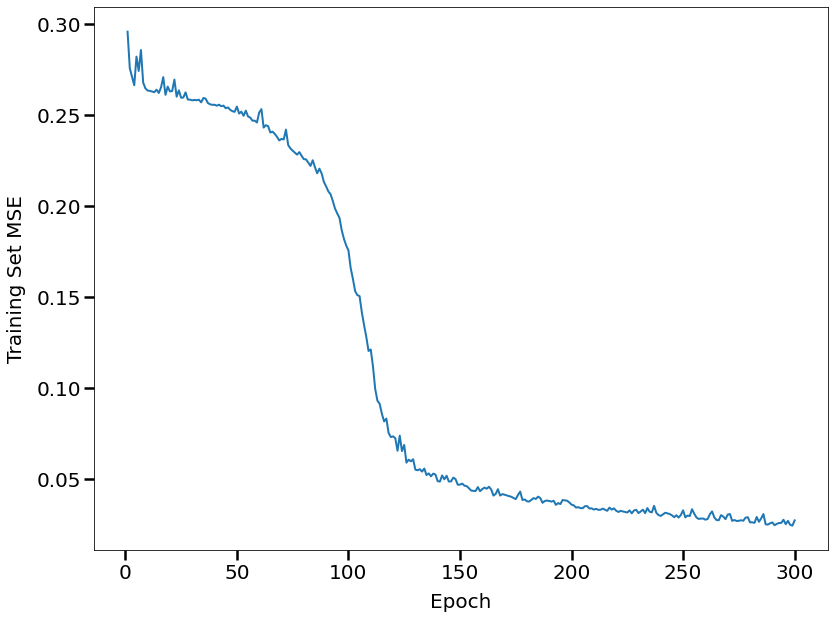

In [4]:
# create and fit an instance of our simple MLP model given our training data
mlp_model = SimpleMLP(hidden_size=32)
loss_list = mlp_model.fit(x_train, y_train)

# plot the evolution of the training MSE
plt.figure()
plt.plot(list(range(1, 1 + len(loss_list))), loss_list)
plt.xlabel('Epoch')
plt.ylabel('Training Set MSE')
plt.tight_layout()

Let us also compare the input/output response of the system to the true system and see how it performs on unseen
samples from our test set!

Training MSE is 0.03
Test MSE is 0.50


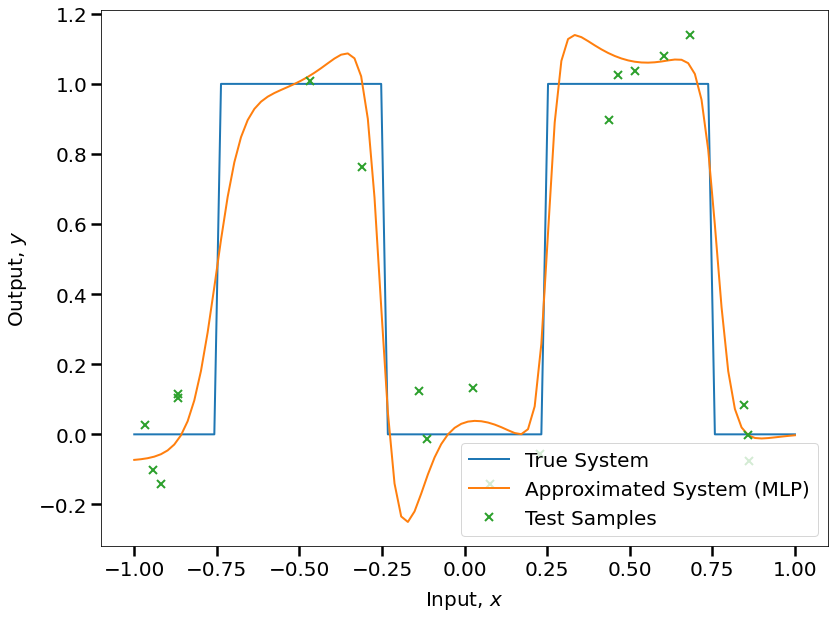

In [5]:
# compute the approximated system behavior and the prediction for our test set
approx_output = mlp_model.predict(support)
y_pred = mlp_model.predict(x_test)

print(f'Training MSE is {loss_list[-1]:.2f}')
print(f'Test MSE is {np.mean((y_test - y_pred)**2):.2f}')

# plot the true and approximated systems with the test samples
plt.figure()
plt.plot(support, true_output, label='True System')
plt.plot(support, approx_output, label='Approximated System (MLP)')
plt.plot(x_test, y_test, 'x', label='Test Samples')
plt.xlabel('Input, $x$')
plt.ylabel('Output, $y$')
plt.legend()
plt.tight_layout()


Simple as that - we did our first system identification with a simple feed-forward neural network!